# Example to run inversion using box model
The inversion estimates the emissions deviation from some a priori value

In [15]:
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path

from py12box_invert.paths import Paths
from py12box_invert.invert import Invert
from py12box_invert.plot import plot_mf, plot_emissions

species = "CFC-11"
project_path = Paths.data / f"example/{species}"

This runs the inversion to estimate yearly emissions different to a priori for each box

In [2]:
inv = Invert(project_path, species, method="mcmc_analytical", n_threads=4, sensitivity_freq="yearly", start_year=2010, end_year=2020)
inv.create_matrices([70., 20., 10., 10.])

Setting up inversion for CFC-11

No units given for emissions. Assuming Gg/yr
No inital conditions file 
... assuming zero initial conditions
Compiling model and tuning lifetime...
... completed in 3 iterations
... stratospheric lifetime: 55.0
... OH lifetime: 1e12
... ocean lifetime: 1e12
... non-OH tropospheric lifetime: 1e12
... overall lifetime: 55.0
... done in 3.0203 s


/Users/chxmr/code/py12box_invert/py12box_invert/invert.py:117: UserWarning: Can't have both a start_year and ic_year
 Setting ic_years to None.
  warnings.warn("Can't have both a start_year and ic_year\n Setting ic_years to None.")


Calculating flux sensitivity on 4 threads...


WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


... done
Spinning up for 9 years and estimating initial conditions...
... done


In [7]:

with pm.Model() as model:
    x = pm.MvNormal("x", mu=inv.mat.x_a, tau=inv.mat.P_inv, shape=(inv.mat.x_a.shape[0]))
    y_observed = pm.MvNormal(
        "y",
        mu=inv.mat.H @ x,
        cov=inv.mat.R,
        observed=inv.mat.y,
    )
    trace = pm.sample(return_inferencedata=True)
#    trace = pm.sample(20000, tune=10000, chains=2, step=pm.Metropolis(),
#                    return_inferencedata=True, progressbar=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 524 seconds.


In [8]:

inv.mat.x_trace = trace.posterior.sel(chain=0).x.data

# Store x and P to make posterior processing simpler (but don't use this for posterior ensemble)
inv.mat.x_hat = trace.posterior.sel(chain=0).x.mean(dim="draw").data
inv.mat.P_hat = trace.posterior.sel(chain=0).x.data.T @ trace.posterior.sel(chain=0).x.data

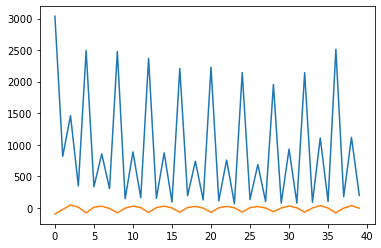

In [17]:
plt.plot(np.sqrt(inv.mat.P_hat.diagonal()))
plt.plot(inv.mat.x_hat)